In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
import shap
import pickle
import cloudpickle
import numpy as np
from comparers import ModelComparer
from explainers import generate_shap_explanations
from plots import plot_decision_boundary, plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                  plot_feature_effects, plot_forces
from util import calc_feature_order, calc_class_order, calc_instance_order
import pandas as pd
import diro2c
from data_generation.helper import prepare_df
from data_generation.neighborhood_generation import neighbor_generator
from enums.diff_classifier_method_type import diff_classifier_method_type
from mlxtend.plotting import plot_decision_regions
from sklearn.tree import plot_tree
import rule_extractor
shap.initjs()
%matplotlib inline
task_name = '02'

In [2]:
with open(task_name + '.dataset', 'rb') as f:
    X, y, feature_names = pickle.load(f)
with open(task_name + '.models', 'rb') as f:
    comparer = pickle.load(f)

# Explain using Interpretability Methods

Prepare dataset for diro2c

In [3]:
idx_explain = 0

In [4]:
feature1 = []
feature2 = []
for x in X:
    feature1.append(x[0])
    feature2.append(x[1])

feature1 = np.asarray(feature1)
feature2 = np.asarray(feature2)

y = y.astype(str)

d = {'y': y, 'feature_1': feature1, 'feature_2': feature2}

df = pd.DataFrame(d)

dataset = prepare_df(df, 'test', 'y')

## Binary difference explanations

In [5]:
diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                              diff_classifier_method_type.binary_diff_classifier,
                                              data_generation_function=neighbor_generator.get_genetic_neighborhood)

In [6]:
dc_info = diff_classifiers_info['binary_diff_classifer']
dc_full = dc_info['dc_full']
dc_test = dc_info['dc_test']
evaluation_info = dc_info['evaluation_info']

X_diff = evaluation_info['X']
y_diff = evaluation_info['y']

print(np.unique(y_diff, return_counts=True))

(array([0, 1]), array([1448,  315]))


Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.


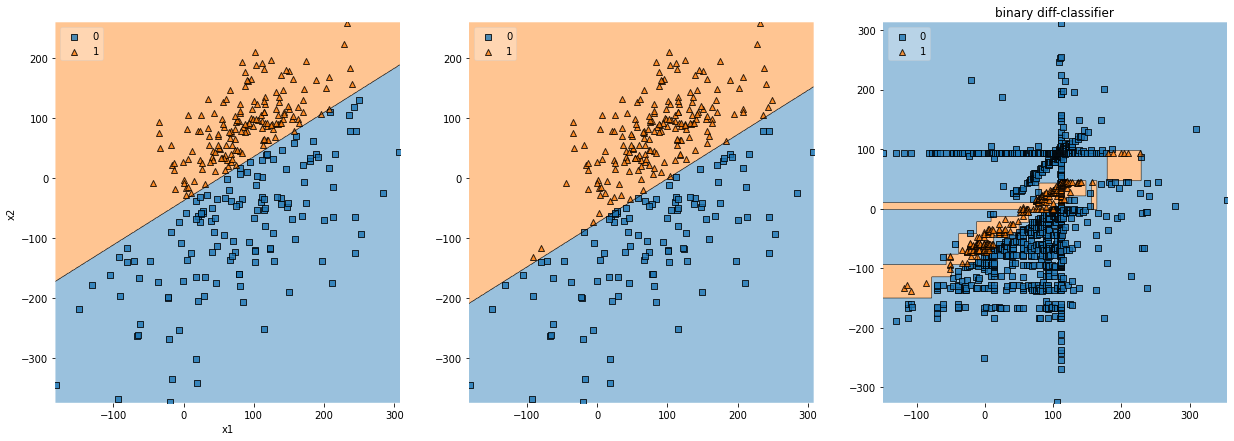

In [7]:
y_pred_a = comparer.clf_a.predict(X)
y_pred_b = comparer.clf_b.predict(X)

fig, ax = plt.subplots(1, 3, figsize=(21, 7))

fig = plot_decision_regions(X=X, y=y_pred_a.astype(
    np.int64), clf=comparer.clf_a, ax=ax[0], legend=2)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
plt.title('blackbox 1')

fig = plot_decision_regions(X=X, y=y_pred_b.astype(
    np.int64), clf=comparer.clf_b, ax=ax[1], legend=2)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
plt.title('blackbox 2')

fig = plot_decision_regions(X=X_diff, y=y_diff.astype(
    np.integer), clf=dc_full, ax=ax[2], legend=2)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
plt.title('binary diff-classifier')

plt.show()

[Text(701.3162878787879, 860.7, 'x2 <= 46.5\ngini = 0.293\nsamples = 1763\nvalue = [1448, 315]\nclass = no_diff'),
 Text(528.9962121212121, 770.1, 'x2 <= -0.5\ngini = 0.41\nsamples = 1075\nvalue = [766, 309]\nclass = no_diff'),
 Text(349.92424242424244, 679.5, 'x1 <= 8.5\ngini = 0.253\nsamples = 841\nvalue = [716, 125]\nclass = no_diff'),
 Text(220.75757575757578, 588.9000000000001, 'x2 <= -76.0\ngini = 0.497\nsamples = 173\nvalue = [80, 93]\nclass = diff'),
 Text(140.9090909090909, 498.3, 'x2 <= -94.0\ngini = 0.249\nsamples = 89\nvalue = [76, 13]\nclass = no_diff'),
 Text(75.15151515151516, 407.70000000000005, 'x1 <= -78.0\ngini = 0.155\nsamples = 71\nvalue = [65, 6]\nclass = no_diff'),
 Text(37.57575757575758, 317.1, 'x2 <= -149.5\ngini = 0.48\nsamples = 10\nvalue = [6, 4]\nclass = no_diff'),
 Text(18.78787878787879, 226.5, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]\nclass = no_diff'),
 Text(56.36363636363637, 226.5, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]\nclass = diff'),
 Text(112.7

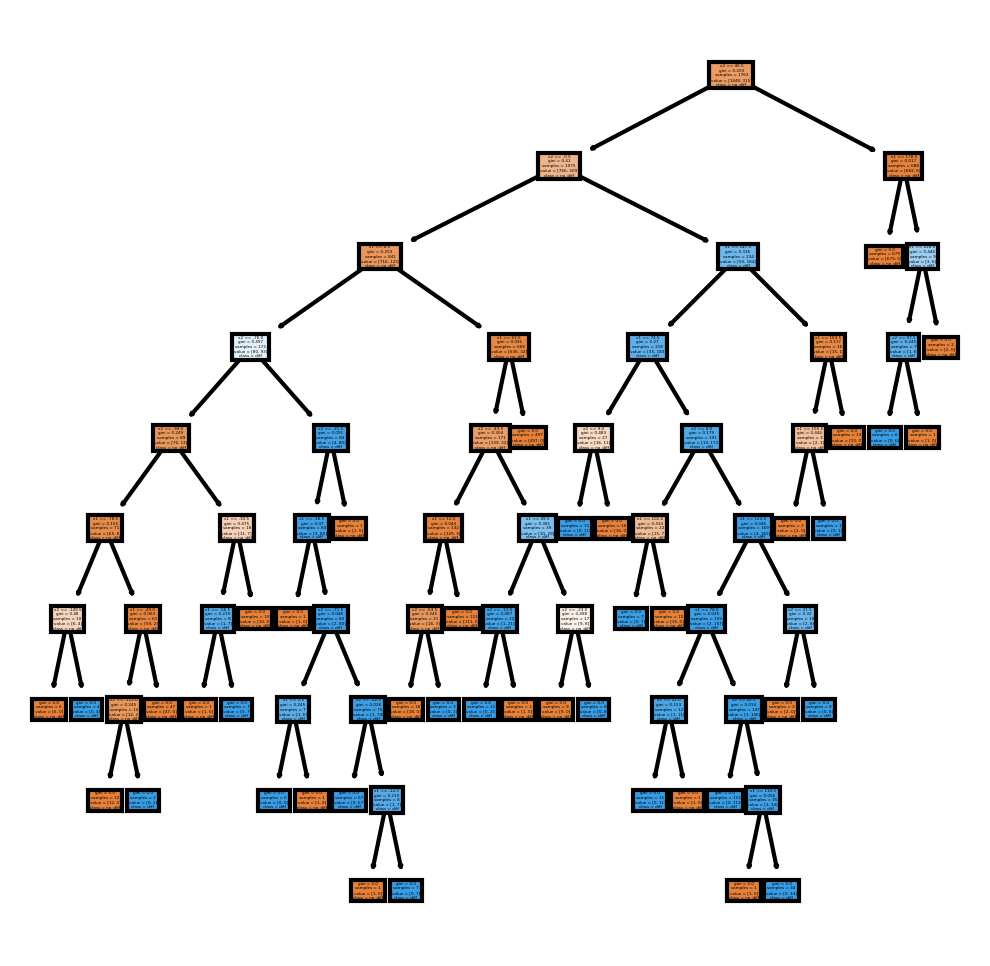

In [8]:
cn = ['no_diff', 'diff']
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)
plot_tree(dc_full,
               feature_names=feature_names,
               class_names=cn,
               filled=True)

In [9]:
rule_extractor.print_rules_for_binary(
    dc_full, dataset['columns_for_decision_rules'], ['no_diff', 'diff'], 'diff')

{'diff': '{feature_2 <= 46.5, feature_2 <= -0.5, feature_1 <= 8.5, feature_2 <= -76.0, feature_2 <= -94.0, feature_1 <= -78.0, feature_2 > -149.5}'}
{'diff': '{feature_2 <= 46.5, feature_2 <= -0.5, feature_1 <= 8.5, feature_2 <= -76.0, feature_2 <= -94.0, feature_1 > -78.0, feature_1 <= -49.0, feature_2 > -115.0}'}
{'diff': '{feature_2 <= 46.5, feature_2 <= -0.5, feature_1 <= 8.5, feature_2 <= -76.0, feature_2 > -94.0, feature_1 <= -10.5, feature_1 > -56.5}'}
{'diff': '{feature_2 <= 46.5, feature_2 <= -0.5, feature_1 <= 8.5, feature_2 > -76.0, feature_2 <= -21.5, feature_1 > -38.5, feature_2 <= -71.5, feature_1 <= 3.5}'}
{'diff': '{feature_2 <= 46.5, feature_2 <= -0.5, feature_1 <= 8.5, feature_2 > -76.0, feature_2 <= -21.5, feature_1 > -38.5, feature_2 > -71.5, feature_2 <= -42.0}'}
{'diff': '{feature_2 <= 46.5, feature_2 <= -0.5, feature_1 <= 8.5, feature_2 > -76.0, feature_2 <= -21.5, feature_1 > -38.5, feature_2 > -71.5, feature_2 > -42.0, feature_1 > -12.0}'}
{'diff': '{feature_2 

## Multiclass difference explanations

In [10]:
multiclass_diff_names = ['(0, 0)', '(1, 1)', '(1, 0)', '(0, 1)']

In [11]:
diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                              diff_classifier_method_type.multiclass_diff_classifier,
                                              data_generation_function=neighbor_generator.get_genetic_neighborhood)

In [12]:
dc_info = diff_classifiers_info['multiclass_diff_classifer']
dc_full = dc_info['dc_full']
dc_test = dc_info['dc_test']
evaluation_info = dc_info['evaluation_info']

X_diff = evaluation_info['X']
y_diff = evaluation_info['y']

print(np.unique(y_diff, return_counts=True))

(array([1, 2, 4]), array([651, 852, 414]))


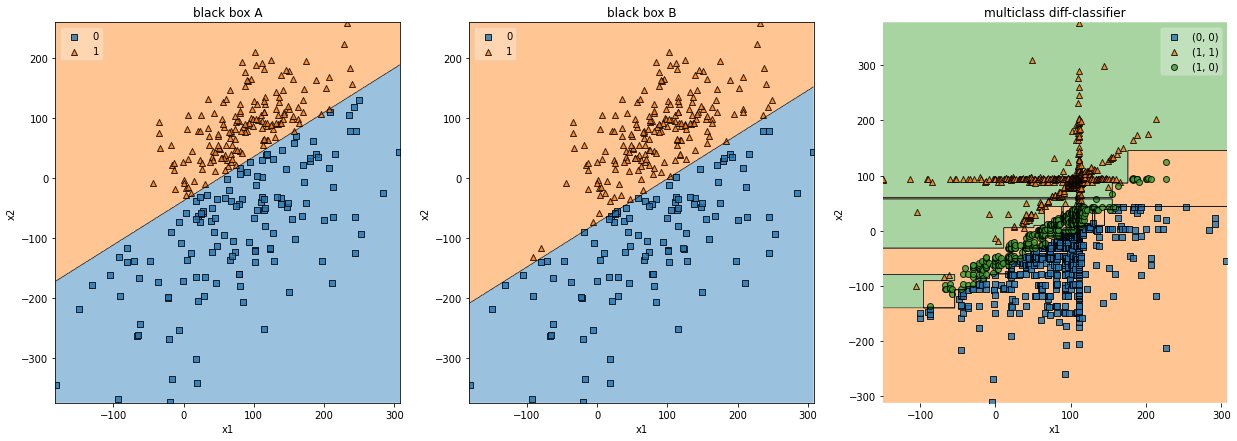

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7))

fig = plot_decision_regions(X=X, y=y_pred_a.astype(
    np.int64), clf=comparer.clf_a, ax=ax[0], legend=2, hide_spines=False)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
ax[0].set_title('black box A')

fig = plot_decision_regions(X=X, y=y_pred_b.astype(
    np.int64), clf=comparer.clf_b, ax=ax[1], legend=2, hide_spines=False)
ax[1].set_xlabel(feature_names[0])
ax[1].set_ylabel(feature_names[1])
ax[1].set_title('black box B')

fig = plot_decision_regions(X=X_diff, y=y_diff.astype(
    np.int64), clf=dc_full, ax=ax[2], legend=2)
ax[2].set_xlabel(feature_names[0])
ax[2].set_ylabel(feature_names[1])
ax[2].set_title('multiclass diff-classifier')

handles, labels = ax[2].get_legend_handles_labels()
ax[2].legend(handles,
             multiclass_diff_names,
             framealpha=0.3, scatterpoints=1)

plt.show()


[Text(711.6959134615385, 868.25, 'x2 <= 43.5\ngini = 0.641\nsamples = 1917\nvalue = [651, 852, 414]\nclass = (1, 1)'),
 Text(561.3533653846154, 792.75, 'x2 <= 9.5\ngini = 0.5\nsamples = 1078\nvalue = [651, 32, 395]\nclass = (0, 0)'),
 Text(435.9375, 717.25, 'x1 <= 66.5\ngini = 0.358\nsamples = 822\nvalue = [633, 8, 181]\nclass = (0, 0)'),
 Text(342.49038461538464, 641.75, 'x2 <= -31.5\ngini = 0.524\nsamples = 305\nvalue = [142, 8, 155]\nclass = (1, 0)'),
 Text(255.75, 566.25, 'x1 <= 21.5\ngini = 0.486\nsamples = 228\nvalue = [139, 3, 86]\nclass = (0, 0)'),
 Text(168.1153846153846, 490.75, 'x2 <= -79.0\ngini = 0.511\nsamples = 148\nvalue = [63, 3, 82]\nclass = (1, 0)'),
 Text(78.6923076923077, 415.25, 'x1 <= -53.5\ngini = 0.411\nsamples = 71\nvalue = [52, 3, 16]\nclass = (0, 0)'),
 Text(28.615384615384617, 339.75, 'x2 <= -139.5\ngini = 0.611\nsamples = 18\nvalue = [6, 3, 9]\nclass = (1, 0)'),
 Text(14.307692307692308, 264.25, 'gini = 0.0\nsamples = 6\nvalue = [6, 0, 0]\nclass = (0, 0)')

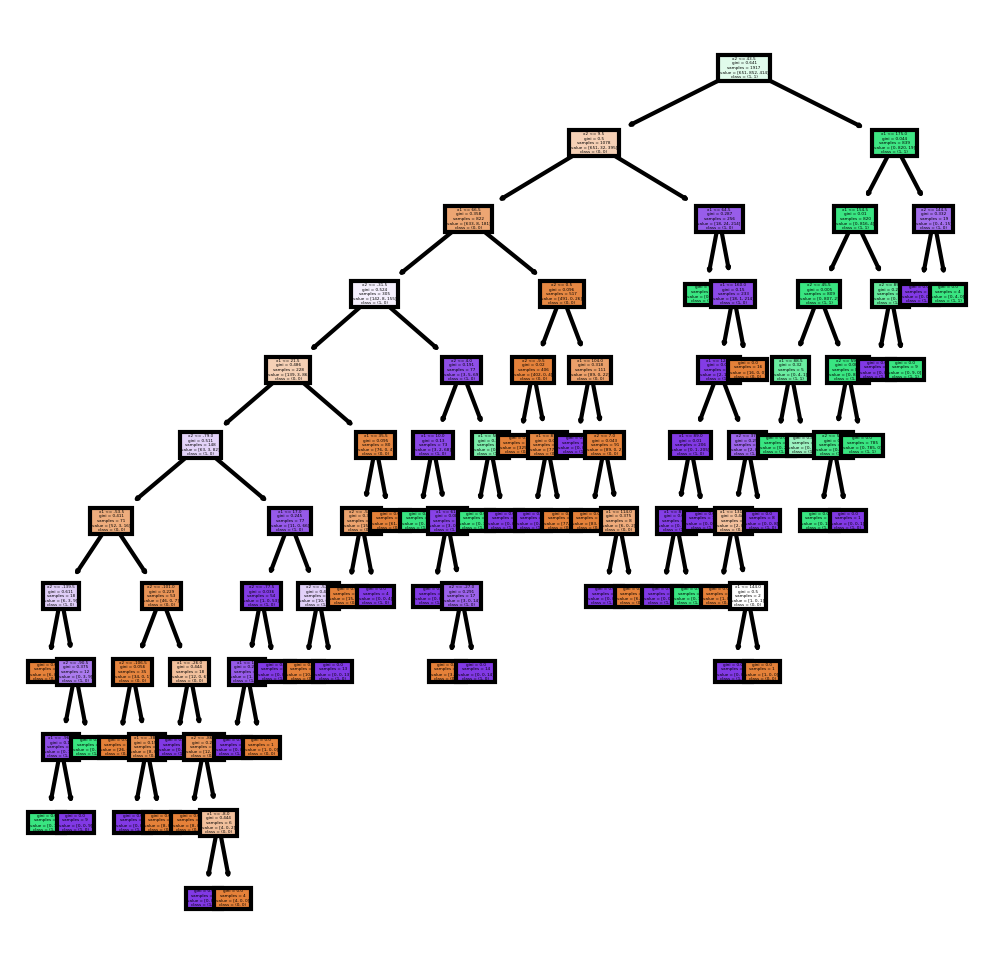

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)
plot_tree(dc_full,
               feature_names=feature_names,
               class_names=multiclass_diff_names,
               filled=True)